In [41]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import glob   #The glob module in Python is used to find all pathnames matching a specified pattern. It is inspired by the UNIX shell's pattern matching.
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.src.utils import to_categorical


In [42]:
# Parameters
DATA_DIR  = 'Udyam/'
H, W, C = 50, 200, 3  # height, width, channels
D = 6  # Number of characters per image
characters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
N_LABELS = len(characters)  # 62 labels

In [43]:
# Mapping characters to numbers and vice versa
char_to_num = {char: idx for idx, char in enumerate(characters)}
num_to_char = {idx: char for char, idx in char_to_num.items()}

In [44]:
# Parse file path to extract label
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        # label, _ = filename.split("_")
        return filename
    except Exception as e:
        print(f'Error parsing {filepath}: {e}')
        return None, None

In [45]:
# Load and prepare the data
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))
for i in attributes:
    if(len(i)!=6):
        print(i)
df = pd.DataFrame(attributes, columns=['label'])
df['file'] = files
df = df.dropna()

In [46]:
# Split data into training, validation, and test sets
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.9)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]


train_up_to = int(train_up_to * 0.90)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print(f'train count: {len(train_idx)}, valid count: {len(valid_idx)}, test count: {len(test_idx)}')


train count: 19745, valid count: 2194, test count: 2438


In [47]:
# Data generator
def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file).resize((W, H))  # Resize to (W, H)
            im = np.array(im) / 255.0
            images.append(np.array(im))
            label_array=np.array([to_categorical(char_to_num[char], N_LABELS) for char in label])
            # print(len(label_array))
            labels.append(label_array)
#             print(len(labels))
            # print(IMAGE.shape,LABEL.shape)
            if len(images) >= batch_size:
                yield np.array(images),np.array(labels)
                images, labels = [], []
        if not for_training:
            break


In [48]:
# Model definition
input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 198, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 9, 46, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5888)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     6,030,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 372)            │       381,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 6, 62)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,467,956 (24.67 MB)

 Trainable params: 6,467,956 (24.67 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Train the model
batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 120s 381ms/step - accuracy: 0.4977 - loss: 2.1320 - val_accuracy: 0.8795 - val_loss: 0.7756
Epoch 2/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 110s 356ms/step - accuracy: 0.8856 - loss: 0.7052 - val_accuracy: 0.8798 - val_loss: 0.7474
Epoch 3/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 123s 399ms/step - accuracy: 0.8866 - loss: 0.6027 - val_accuracy: 0.8743 - val_loss: 0.7815
Epoch 4/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 108s 352ms/step - accuracy: 0.8896 - loss: 0.5130 - val_accuracy: 0.8657 - val_loss: 0.8620
Epoch 5/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 164s 533ms/step - accuracy: 0.8967 - loss: 0.4260 - val_accuracy: 0.8352 - val_loss: 0.9123


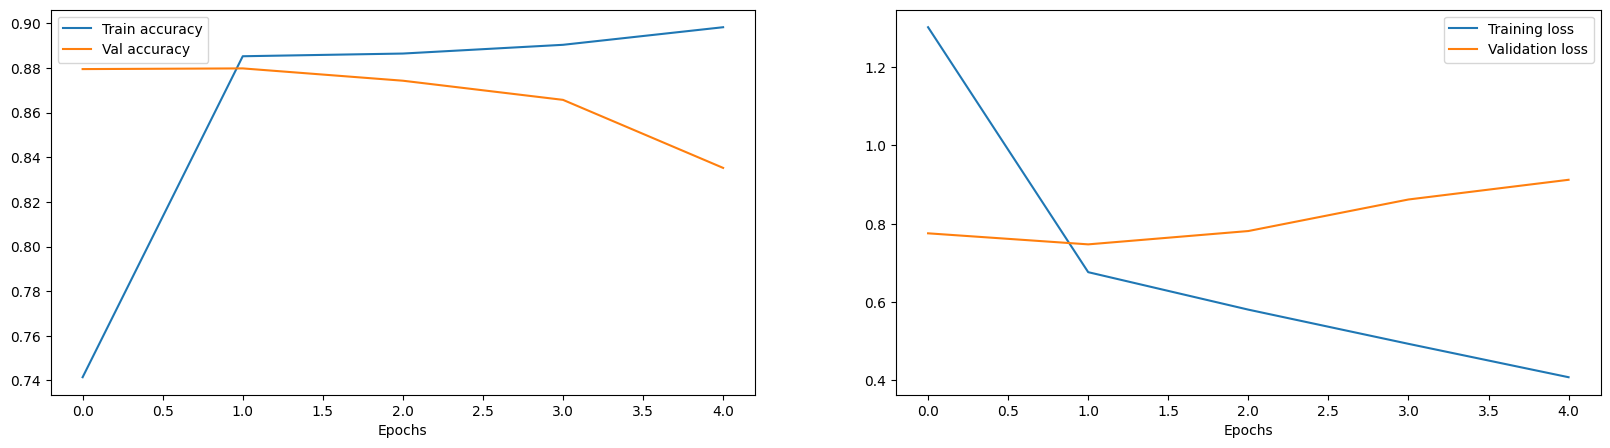

In [50]:
# Plot training history
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()


In [51]:
# Evaluate the model
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 463ms/step - accuracy: 0.8529 - loss: 0.8279


{'loss': 0.8534244894981384, 'compile_metrics': 0.8466967344284058}

In [52]:
# Decode the predictions
def format_y(y):
    return ''.join(map(lambda x: num_to_char[int(x)], y))


In [53]:
# Display predictions
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)
y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

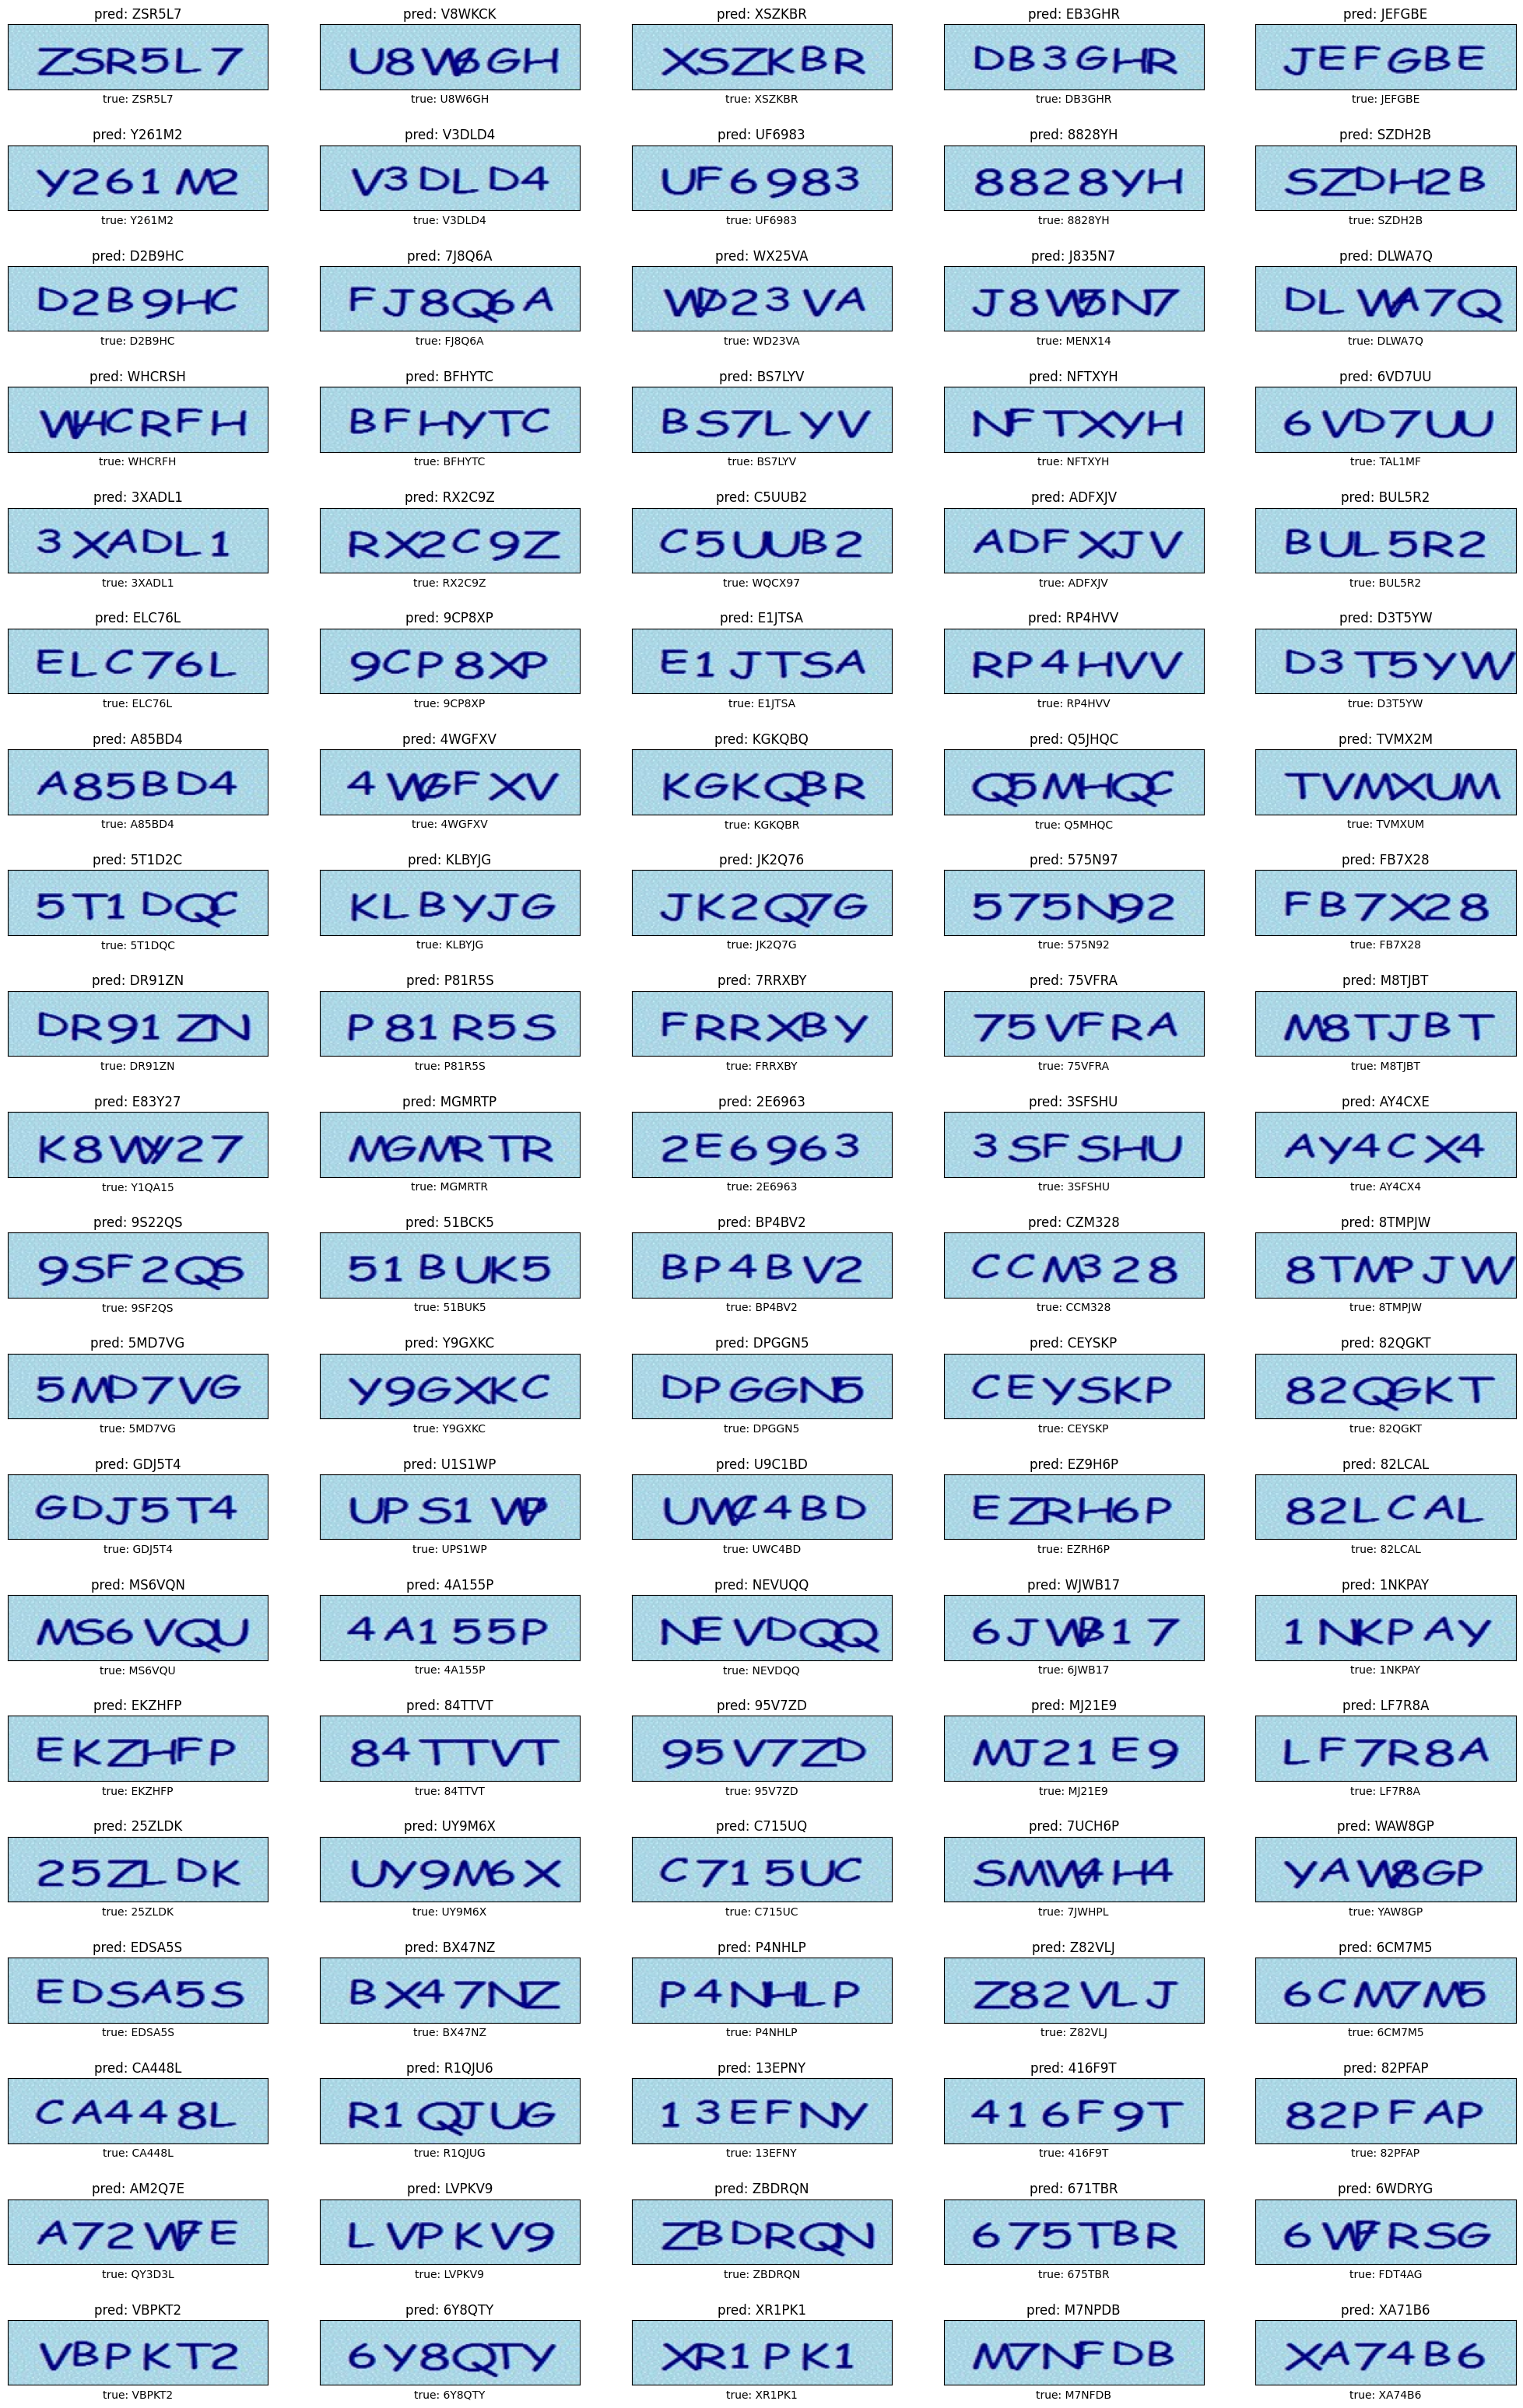

True predicted = 63
False predicted = 37


In [54]:
n = 100
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = np.ceil(n / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 40))
true_count = 0
false_count = 0
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title(f'pred: {format_y(y_pred[img_idx])}')
    ax.set_xlabel(f'true: {format_y(y_true[img_idx])}')
    ax.set_xticks([])
    ax.set_yticks([])
    if np.array_equal(y_pred[img_idx], y_true[img_idx]):
        true_count += 1
    else:
        false_count += 1
plt.show()

print(f"True predicted = {true_count}")
print(f"False predicted = {false_count}")
